# Imports

In [1]:
# %matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import finananal  as finan
import datetime as dt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from tensorflow.keras import layers
from tensorflow.keras import models

import pickle

from sklearn.externals import joblib 

/home/marcelo/anaconda3/envs/jupyter/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Tensorflow and notebook prep.

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
pd.options.display.max_columns = None

# Reading the files

In [4]:
start = dt.datetime(1989, 1, 1)
end = dt.datetime(2020, 1, 9)
start_plot = dt.datetime(2019, 6, 1)
end_plot = dt.datetime(2020, 1, 9)

In [5]:
model = models.load_model('saved_model/sp500_all_LSTM_1_2304_closech', custom_objects=None, compile=True)

In [6]:
x_train = pd.read_pickle(r'data_train_val/X_data_train_2_1604')
x_val = pd.read_pickle(r'data_train_val/X_data_val_2_1604')
y_train = pd.read_pickle(r'data_train_val/y_data_train_2_1604')
y_val = pd.read_pickle(r'data_train_val/y_data_val_2_1604')

In [7]:
x_val.shape

(1044, 45, 43, 41)

In [8]:
x_train[0][0].shape

(43, 41)

In [9]:
sp500 = pd.read_csv('/home/marcelo/Downloads/^GSPC.csv', parse_dates=True, index_col=0)
sp500 = sp500.asfreq(freq='B', method = 'pad')
sp500 = sp500.drop('Adj Close', axis =1)
sp500 = sp500[start:end]
sp500

,Open,High,Low,Close,Volume
Date,,,,,
1989-01-02,279.390015,279.779999,277.720001,277.720001,127210000
1989-01-03,277.720001,277.720001,273.809998,275.309998,128500000
1989-01-04,275.309998,279.750000,275.309998,279.429993,149700000
1989-01-05,279.429993,281.510010,279.429993,280.010010,174040000
1989-01-06,280.010010,282.059998,280.010010,280.670013,161330000
...,...,...,...,...,...
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3461290000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3674070000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3420380000


In [10]:
y = pd.read_pickle(r'multiplexed/y_1604_1closech.pkl')

In [11]:
y

Date
1989-01-02     0.000000
1989-01-03    -2.410003
1989-01-04     4.119995
1989-01-05     0.580017
1989-01-06     0.660003
                ...    
2020-01-03   -23.000000
2020-01-06    11.429931
2020-01-07    -9.100097
2020-01-08    15.870117
2020-01-09    21.649902
Freq: B, Name: Close Change, Length: 8094, dtype: float64

# Desnormalization

In [12]:
## Close vector desnormalization

def desnorm(df_norm, df):
    df_desnorm = []
    for i in range(len(df_norm)):
        vect_desnorm = df
        df_desnorm.append(df_norm * (vect_desnorm.max()-vect_desnorm.min()) + vect_desnorm.min())
    return df_desnorm

In [13]:
## Vector Desnormalization

def vect_desnorm(y, y_norm):
    y_desnorm = y_norm * (y.max() - y.min()) + y.min()
    return y_desnorm

In [14]:
def df_desnorm(X, df):
    x_train = X
    x_desnorm_train = []
    for i in range(len(x_train)):
        x_desnorm_train.append(desnorm(x_train[i,:,0,0], df['Close']))
    return np.array(x_desnorm_train)

In [15]:
y_desnorm_train = vect_desnorm(y, y_train)
y_desnorm_val = vect_desnorm(y, y_val)

In [16]:
%%time

x_desnorm_val = df_desnorm(x_val, sp500)
x_desnorm_val[0][0]

CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


array([2104.05  , 2109.79  , 2102.31  , 2099.93  , 2099.2   , 2078.58  ,
       2081.72  , 2075.    , 2045.97  , 2023.04  , 2053.19  , 2050.44  ,
       2083.58  , 2081.24  , 2089.17  , 2086.59  , 2089.14  , 2088.87  ,
       2088.87  , 2090.11  , 2080.41  , 2102.63  , 2079.51  , 2049.62  ,
       2091.69  , 2077.07  , 2063.59  , 2047.6201, 2052.23  , 2012.3699,
       2021.94  , 2043.4099, 2073.07  , 2041.8899, 2005.55  , 2021.1499,
       2038.9697, 2064.29  , 2060.99  , 2060.99  , 2056.5   , 2078.36  ,
       2063.36  , 2043.94  , 2043.94  ], dtype=float32)

In [17]:
%%time

x_desnorm_train = df_desnorm(x_train, sp500)
x_desnorm_train[0][0]

CPU times: user 1min 6s, sys: 44.7 ms, total: 1min 6s
Wall time: 1min 6s


array([277.72, 275.31, 279.43, 280.01, 280.67, 280.98, 280.38, 282.01,
       283.17, 283.87, 284.14, 283.55, 286.53, 286.91, 286.63, 284.5 ,
       288.49, 289.14, 291.69, 293.82, 294.99, 297.47, 297.09, 296.84,
       296.97, 296.04, 299.63, 298.65, 296.06, 292.02, 292.54, 291.81,
       294.24, 294.81, 296.76, 296.76, 295.98, 290.91, 292.05, 287.13,
       287.82, 288.86, 287.11, 289.95, 291.18], dtype=float32)

# Predictor

### Predicciones desnomalizadas

In [18]:
y_pred_train = model.predict(x_train.reshape(6955,45,43,41,1))

In [19]:
y_pred_train[0]

array([0.49157187, 0.49239063, 0.49906135, 0.49832866, 0.492451  ],
      dtype=float32)

In [20]:
y_train[0]

array([0.50837743, 0.48848966, 0.4934942 , 0.49192762, 0.48801103],
      dtype=float32)

In [21]:
y_pred_val = model.predict(x_val.reshape(1044,45,43,41,1))

In [22]:
y_val[0]

array([0.35645637, 0.51020485, 0.37747538, 0.28730562, 0.40093166],
      dtype=float32)

In [23]:
y_pred_val[0]

array([0.5303437 , 0.45610937, 0.57420236, 0.4694287 , 0.4577019 ],
      dtype=float32)

In [24]:
y_desnorm_pred_train = vect_desnorm(y, y_pred_train)
y_desnorm_pred_val = vect_desnorm(y, y_pred_val)

In [25]:
y_desnorm_pred_train[0]

array([-0.23174286, -0.04360199,  1.4892654 ,  1.3209    , -0.02972412],
      dtype=float32)

In [26]:
y_desnorm_train[0]

array([ 3.630005  , -0.94000244,  0.20999146, -0.1499939 , -1.0499878 ],
      dtype=float32)

In [27]:
y_desnorm_pred_val[0]

array([ 8.677628 , -8.380661 , 18.755905 , -5.3200226, -8.014717 ],
      dtype=float32)

In [28]:
y_desnorm_val[0]

array([-31.279907 ,   4.0499268, -26.449951 , -47.170044 , -21.059937 ],
      dtype=float32)

In [29]:
y_desnorm_train[0]

array([ 3.630005  , -0.94000244,  0.20999146, -0.1499939 , -1.0499878 ],
      dtype=float32)

# Graphics

In [30]:
def create_time_steps(length):
    return list(range(-length, 0))

In [31]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History')
#     print(np.array(history[:, 1]))
    plt.plot(np.arange(num_out), np.array(true_future), 'b',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'r',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [32]:
def close_converter(close_real, close_ch):
    close_pred = []
    for i in range(len(close_ch)):
#         print(i)
#         print(close_ch[i])
        if i == 0:
            close_pred.append(close_real[-1] + close_ch[i])
        else:
            close_pred.append(close_pred[i-1] + close_ch[i])
    return np.array(close_pred)

In [33]:
def predictor_plotter(X, y_real, y_pred, start, end, step):
    for i in range(start, end, step):
        x_close = X[i][0]
        y_real_close_ch = y_real[i]
        y_pred_close_ch = y_pred[i]
        close_real = close_converter(x_close, y_real_close_ch)
        close_pred = close_converter(x_close, y_pred_close_ch)
        multi_step_plot(x_close, close_real, close_pred)
    return

In [34]:
x_desnorm_train[0][0]

array([277.72, 275.31, 279.43, 280.01, 280.67, 280.98, 280.38, 282.01,
       283.17, 283.87, 284.14, 283.55, 286.53, 286.91, 286.63, 284.5 ,
       288.49, 289.14, 291.69, 293.82, 294.99, 297.47, 297.09, 296.84,
       296.97, 296.04, 299.63, 298.65, 296.06, 292.02, 292.54, 291.81,
       294.24, 294.81, 296.76, 296.76, 295.98, 290.91, 292.05, 287.13,
       287.82, 288.86, 287.11, 289.95, 291.18], dtype=float32)

In [35]:
close_pred = close_converter(x_desnorm_train[0][0], y_desnorm_pred_train[0])
close_pred

array([290.94824, 290.90463, 292.3939 , 293.71478, 293.68506],
      dtype=float32)

In [36]:
close_real = close_converter(x_desnorm_train[0][0], y_desnorm_train[0])
close_real

array([294.81, 293.87, 294.08, 293.93, 292.88], dtype=float32)

In [37]:
# close_real = []
# for i in range(len(y_desnorm_train[0])):
#     print(i)
#     print(y_desnorm_train[0][i])
#     if i == 0:
#         close_real.append(x_desnorm_train[0][0][-1] + y_desnorm_train[0][i])
#     else:
#         close_real.append(close_real[i-1] + y_desnorm_train[0][i])

In [38]:
close_real

array([294.81, 293.87, 294.08, 293.93, 292.88], dtype=float32)

In [39]:
# close_pred = []
# for i in range(len(y_desnorm_pred_train[0])):
#     print(i)
#     print(y_desnorm_pred_train[0][i])
#     if i == 0:
#         close_pred.append(x_desnorm_train[0][0][-1] + y_desnorm_pred_train[0][i])
#     else:
#         close_pred.append(close_pred[i-1] + y_desnorm_pred_train[0][i])

In [40]:
close_pred

array([290.94824, 290.90463, 292.3939 , 293.71478, 293.68506],
      dtype=float32)

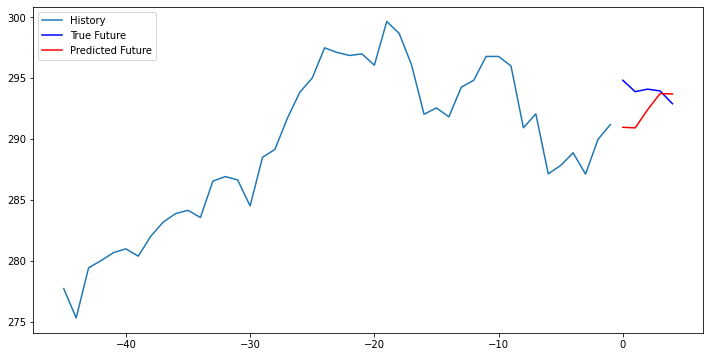

In [41]:
multi_step_plot(x_desnorm_train[0][0], np.array(close_real), np.array(close_pred))

In [42]:
# for i in range(3,15,1):
#     print(i)

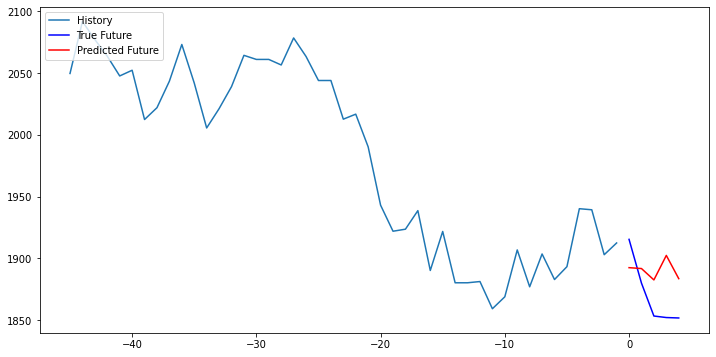

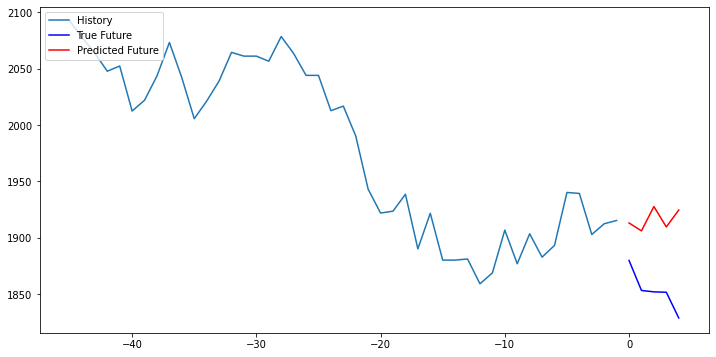

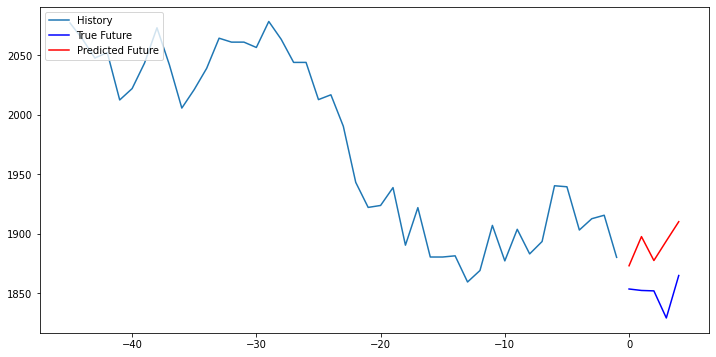

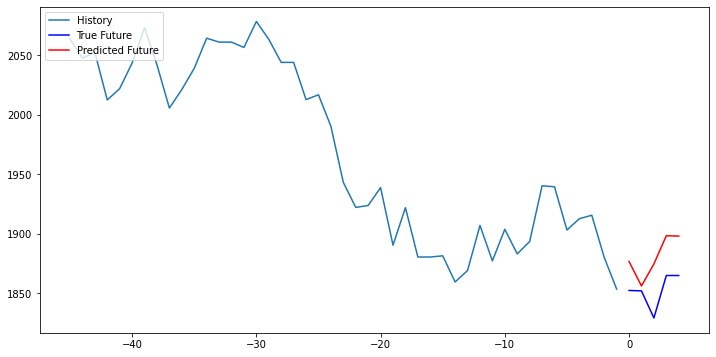

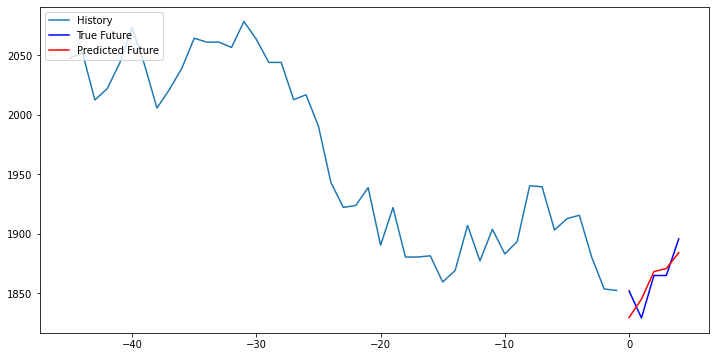

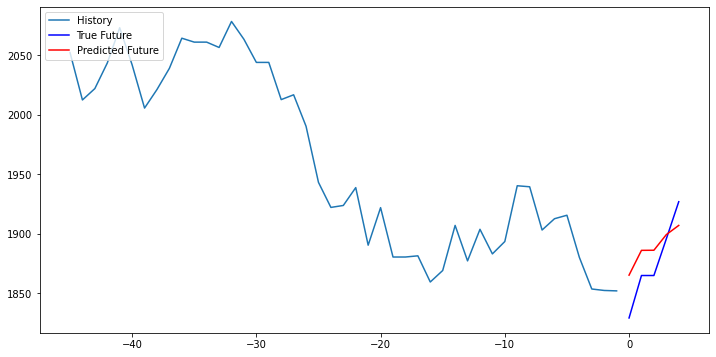

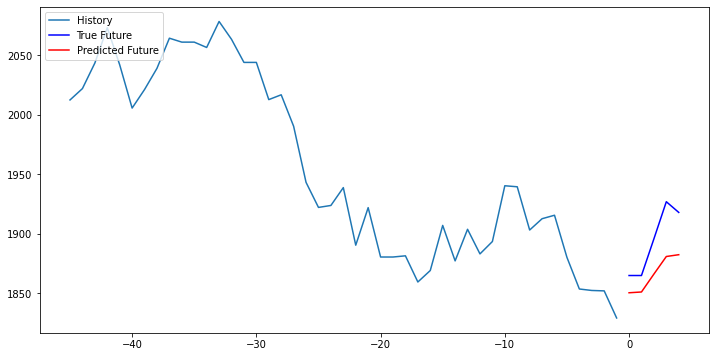

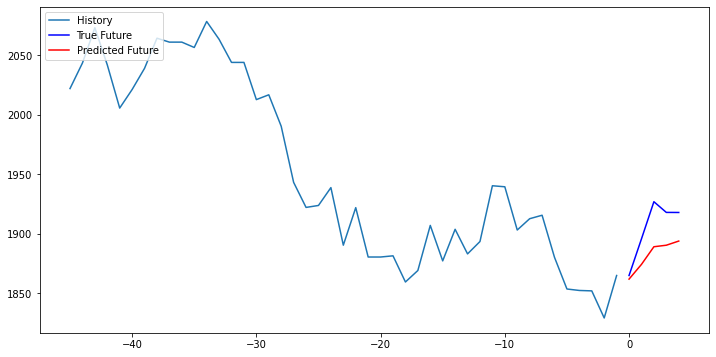

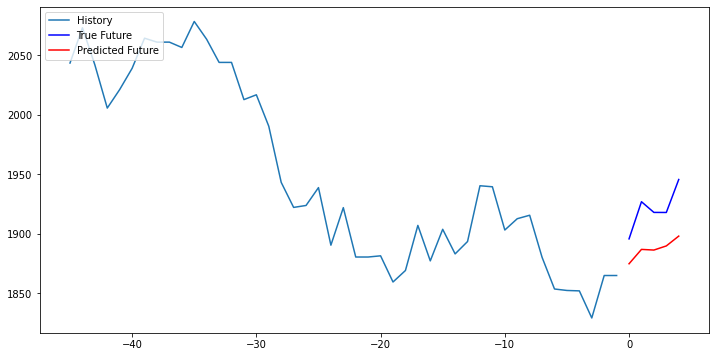

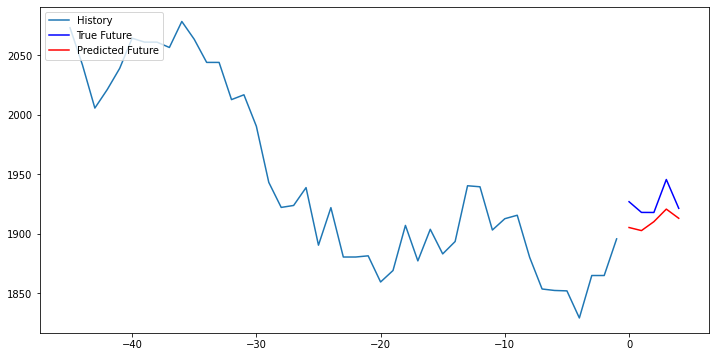

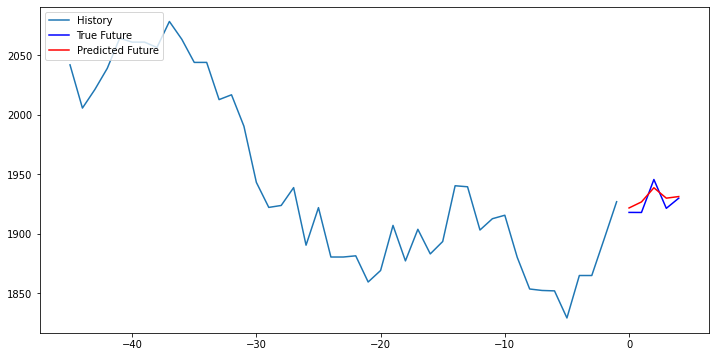

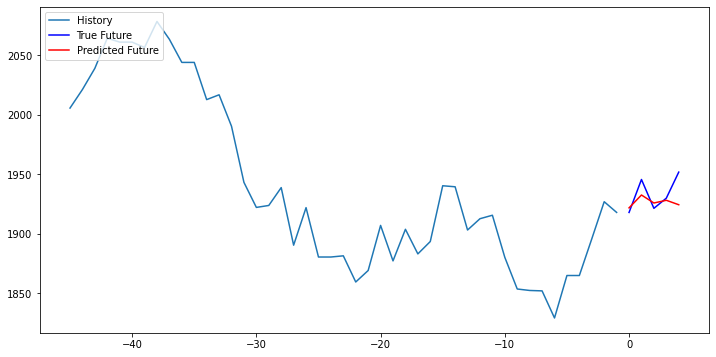

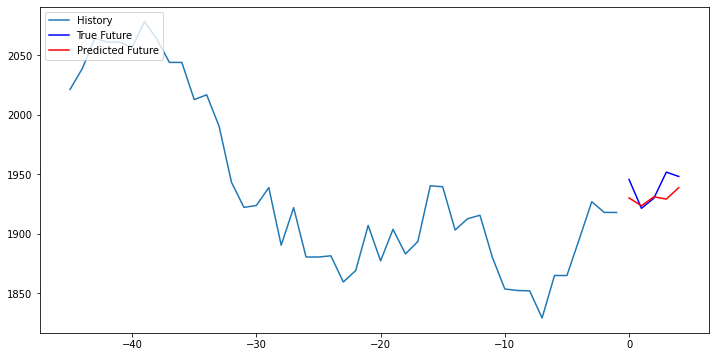

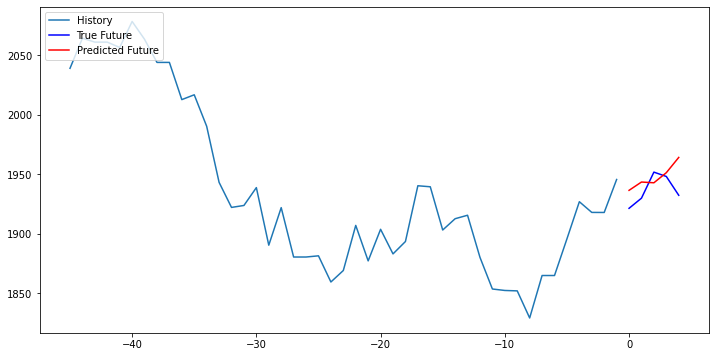

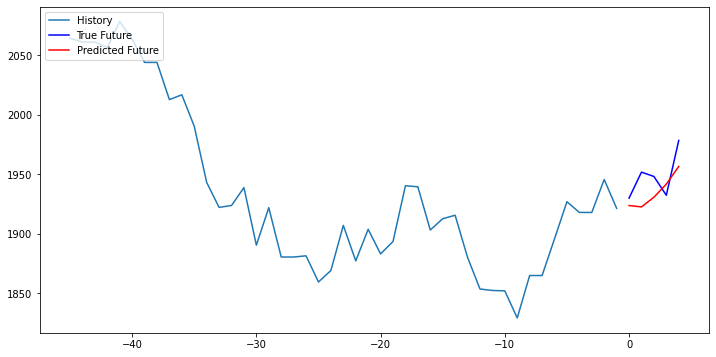

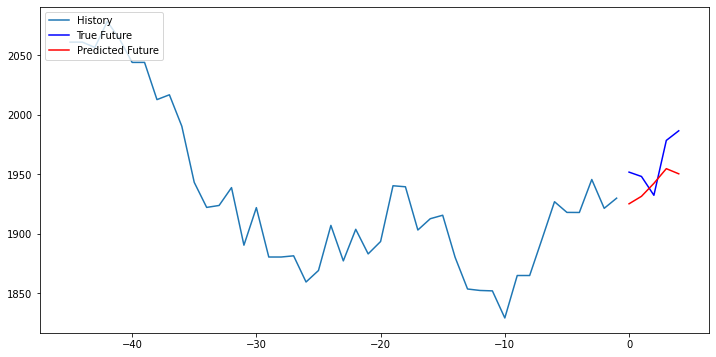

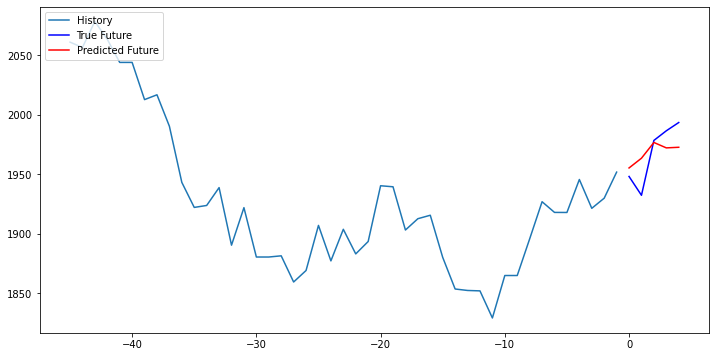

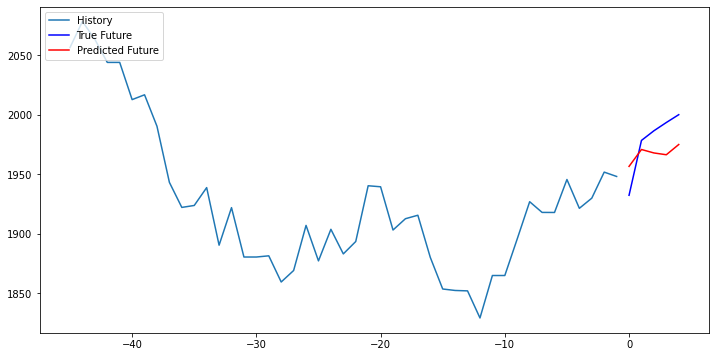

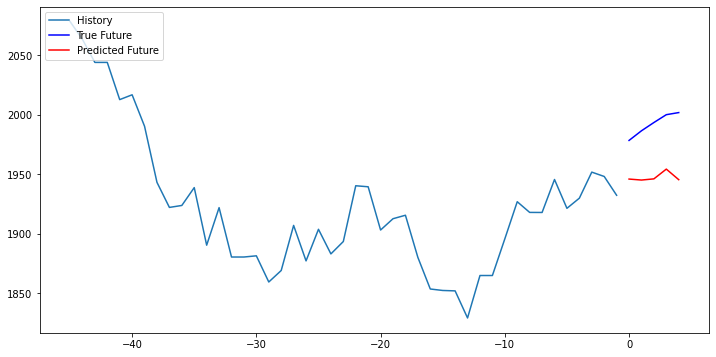

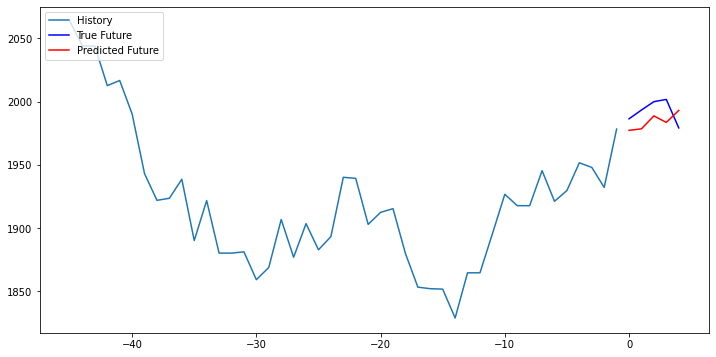

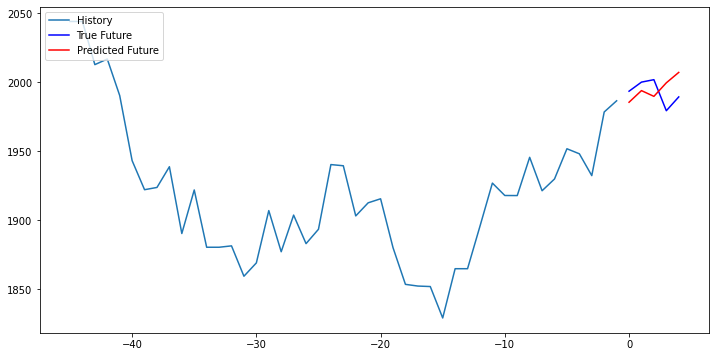

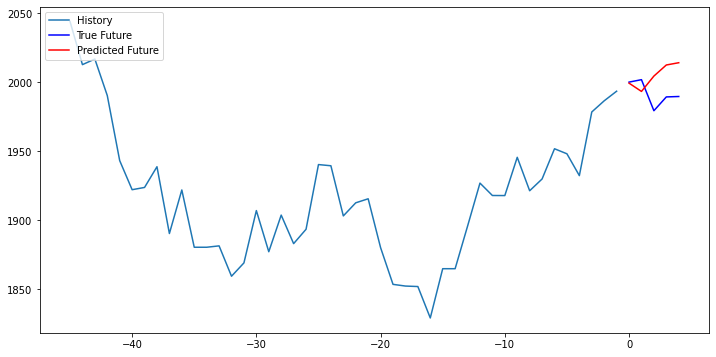

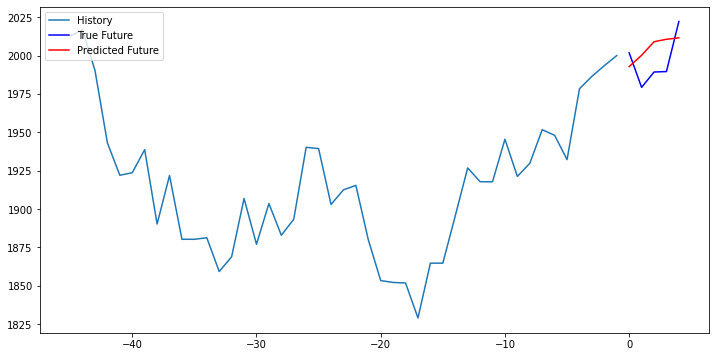

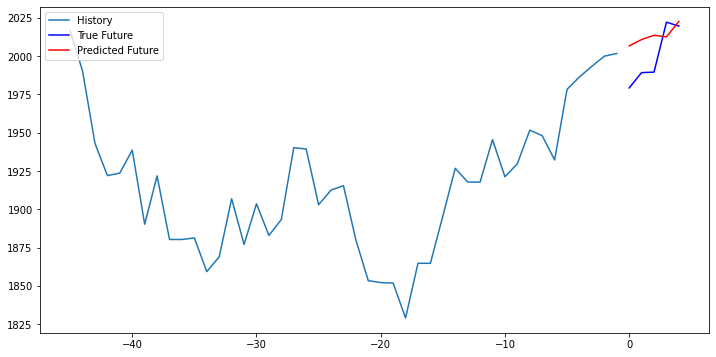

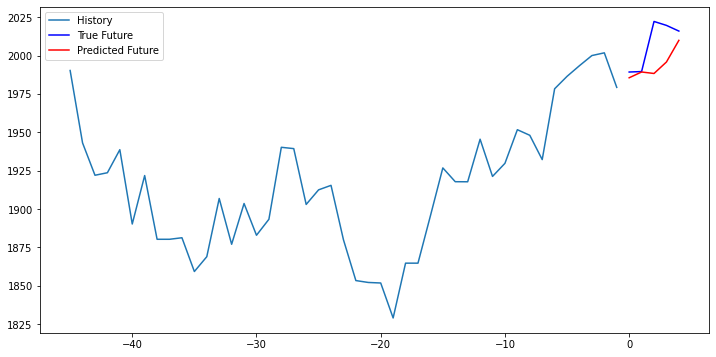

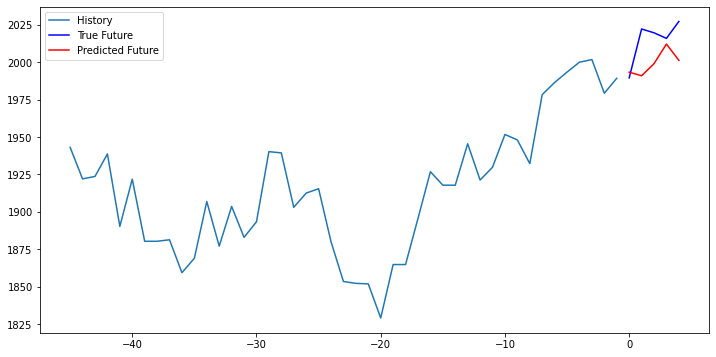

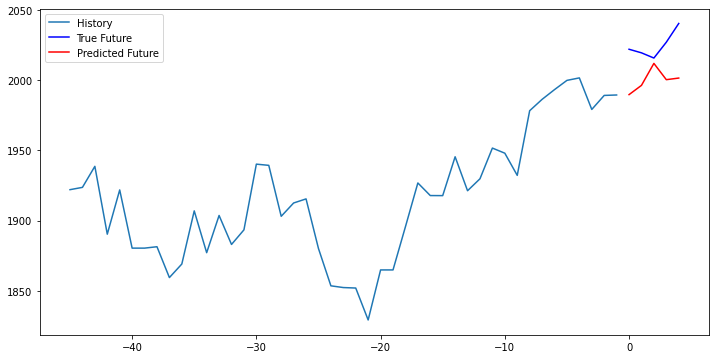

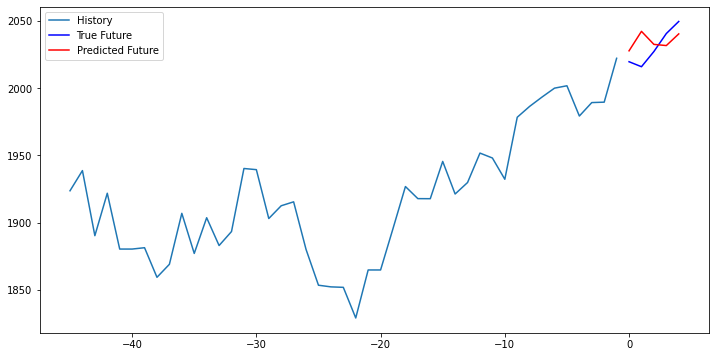

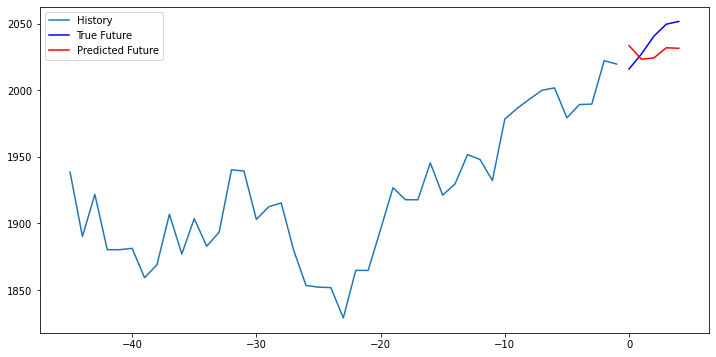

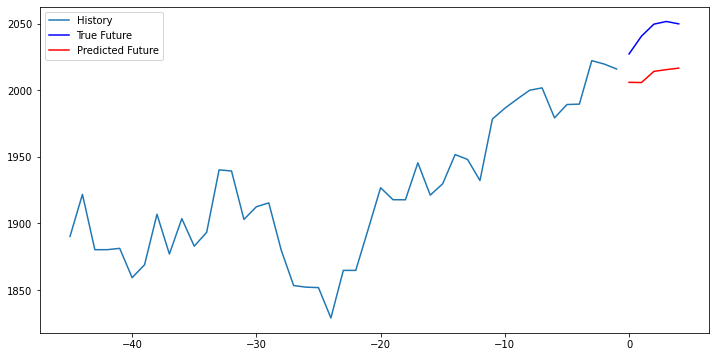

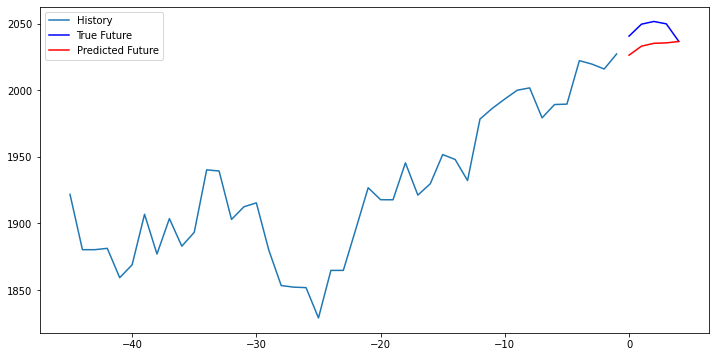

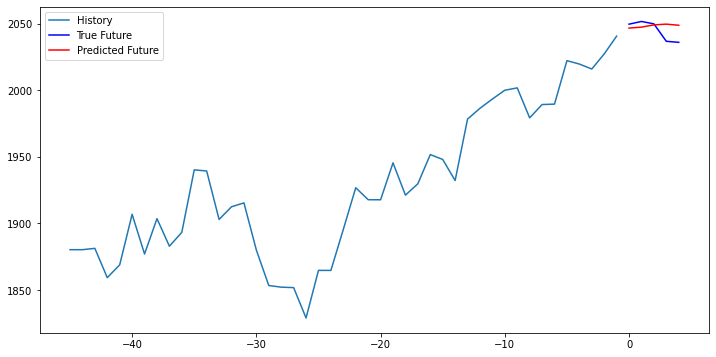

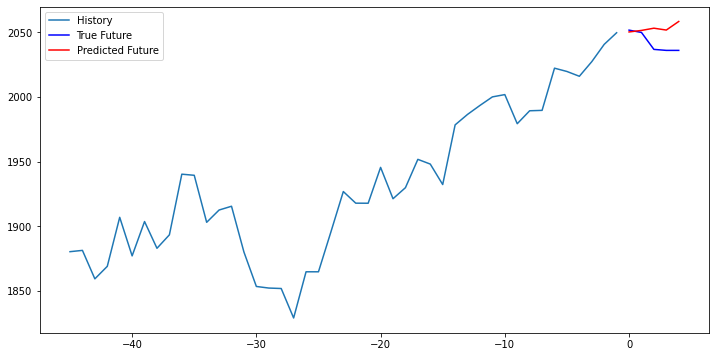

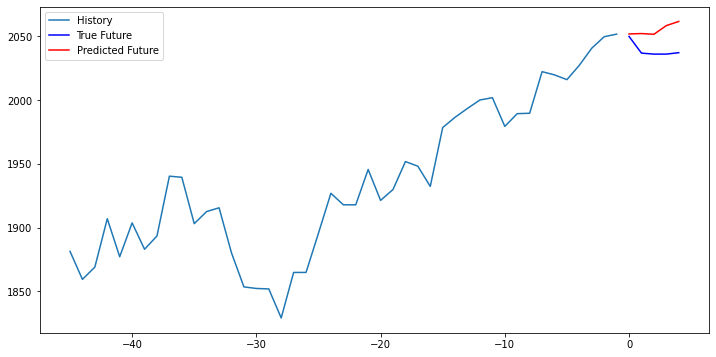

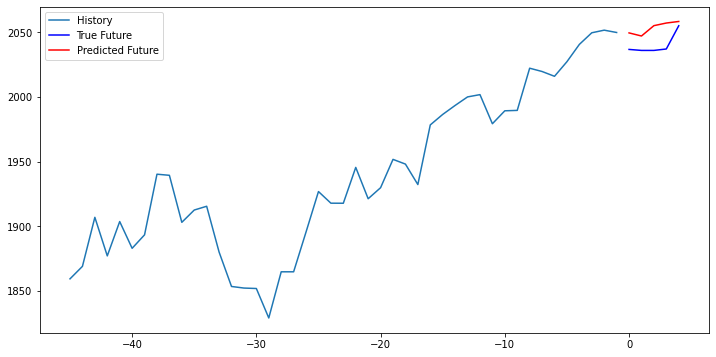

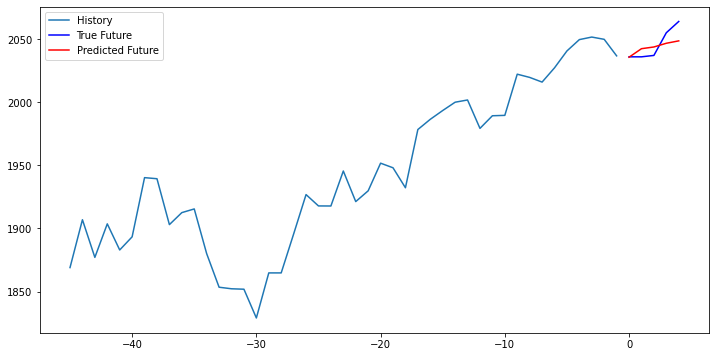

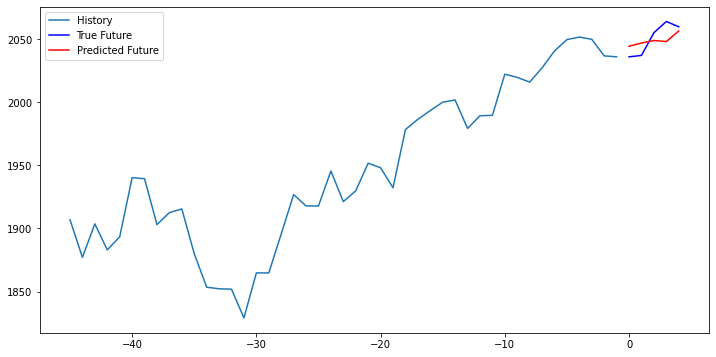

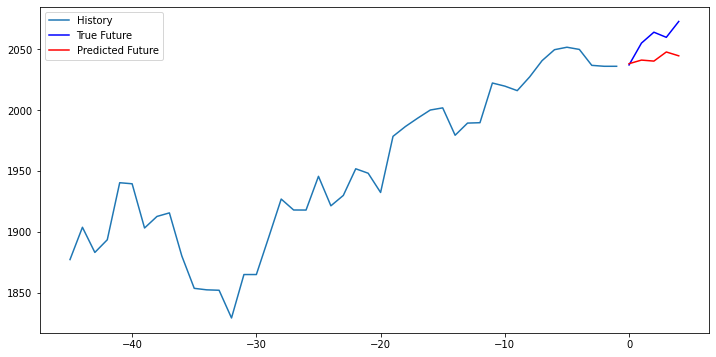

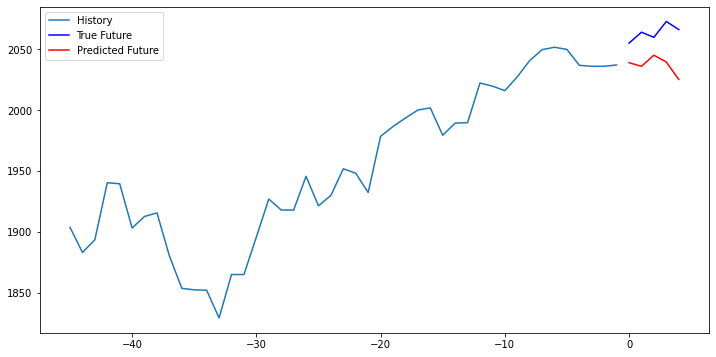

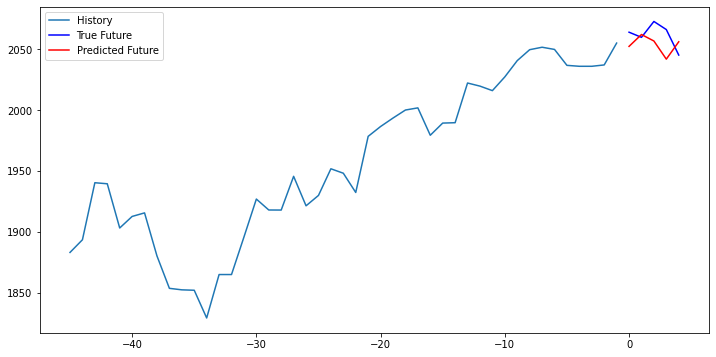

In [43]:
predictor_plotter(x_desnorm_val, y_desnorm_val, y_desnorm_pred_val, 23,63,1)

In [44]:
def trend_acc(X, y_real, y_pred, sign=0):
    close_real = []
    close_pred = []
    eq_trend = 0
    eq_trend_sign = 0
    hist_trend = np.zeros(y_pred.shape[0])
    for i in range(y_pred.shape[0]):
        x_close = X[i][0]
        y_real_close_ch = y_real[i]
        y_pred_close_ch = y_pred[i]
        close_real = close_converter(x_close, y_real_close_ch)
        close_pred = close_converter(x_close, y_pred_close_ch)
#         print(close_pred)
        trend_real = close_real[-1]-close_real[0]
        trend_pred = close_pred[-1]-close_pred[0]
#         multi_step_plot(x_close, close_real, close_pred)
        if np.sign(trend_real) == np.sign(trend_pred):
            eq_trend = eq_trend +1
            hist_trend[i] = 1
        if np.sign(trend_real) == np.sign(trend_pred) == sign:
            eq_trend_sign = eq_trend_sign +1
        
    return eq_trend/y_pred.shape[0], eq_trend_sign/y_pred.shape[0], hist_trend

In [45]:
trend_acc(x_desnorm_train, y_desnorm_train, y_desnorm_pred_train, -1)[1]

0.3033788641265277

In [46]:
trend_acc(x_desnorm_train, y_desnorm_train, y_desnorm_pred_train, 1)[1]

0.5321351545650611

In [47]:
trend_acc(x_desnorm_val, y_desnorm_val, y_desnorm_pred_val, -1)[1]

0.23659003831417624

In [48]:
trend_acc(x_desnorm_val, y_desnorm_val, y_desnorm_pred_val, 1)[1]


0.2413793103448276

In [49]:
def history_calc(X, start, end, step):
    close_hist = []
    for i in range(start, end, step):
        x_close = X[i][0]
        close_hist.append(x_close)
    return np.array(close_hist)

In [50]:
def real_future_calc(X, y_real,start, end, step):
    real_future = []
    for i in range(start, end, step):
        x_close = X[i][0]
        y_real_close_ch = y_real[i]
        close_real = close_converter(x_close, y_real_close_ch)
        real_future.append(close_real)
    return np.array(real_future)

In [51]:
def pred_future_calc(X, y_pred, start, end, step):
    pred_future = []
    for i in range(start, end, step):
        x_close = X[i][0]
        y_pred_close_ch = y_pred[i]
        close_pred = close_converter(x_close, y_pred_close_ch)
        pred_future.append(close_pred)
    return np.array(pred_future)

In [52]:
history_sp500 = history_calc(x_desnorm_val, 0 , 10 , 2)
history_sp500[1]

array([2102.31  , 2099.93  , 2099.2   , 2078.58  , 2081.72  , 2075.    ,
       2045.97  , 2023.04  , 2053.19  , 2050.44  , 2083.58  , 2081.24  ,
       2089.17  , 2086.59  , 2089.14  , 2088.87  , 2088.87  , 2090.11  ,
       2080.41  , 2102.63  , 2079.51  , 2049.62  , 2091.69  , 2077.07  ,
       2063.59  , 2047.6201, 2052.23  , 2012.3699, 2021.94  , 2043.4099,
       2073.07  , 2041.8899, 2005.55  , 2021.1499, 2038.9697, 2064.29  ,
       2060.99  , 2060.99  , 2056.5   , 2078.36  , 2063.36  , 2043.94  ,
       2043.94  , 2012.6602, 2016.71  ], dtype=float32)

In [53]:
real_future_sp500 = real_future_calc(x_desnorm_val, y_desnorm_val, 0 , 10 , 2)

In [54]:
pred_future_sp500 = pred_future_calc(x_desnorm_val, y_desnorm_pred_val, 0 , 10 , 2)

In [55]:
# f = open("normalized/y_norm_1604_1closech-notnorm.pkl","wb")
# pickle.dump(y_norm,f)
# f.close()

In [56]:
plt.figure(figsize=(20,20))
plt.imshow(X_norm[6000])
plt.show()

NameError: name 'X_norm' is not defined

<Figure size 1440x1440 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))
line1, = ax.plot(x, np.sin(x))

def init():  # only required for blitting to give a clean slate.
    line.set_ydata([])
    line1.set_ydata([])
    return line,


def animate(i):
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    line1.set_ydata(np.cos(x + i / 100))
    return line, line1,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()